In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [2]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
total_data = pd.concat([train_data,test_data],axis = 0).reset_index(drop = True)

total_data_ = total_data.copy()


In [3]:
print('train data:', train_data.shape)
print('test data:', test_data.shape)

train_data.columns
test_data.columns
# The test data doesn't have the predictor column. 

train data: (891, 12)
test data: (418, 11)


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train_data.head(3)

# Based on the columns, PassengerId is the unique id for each passenger. 
# Survived is binary variable: whether survived or not. 
# Pclass: Whether the Pclass is 1,3

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
# train_data.info()
total_data.info()


# out of the total 1309 entries, 
# Age is null, cabin is majorly null. 
# and embarked and fare are also null. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Missing Data 

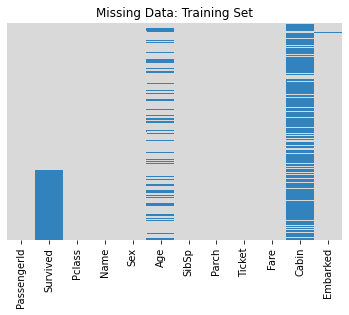

In [6]:
# train_data.isnull() is a binary matrix that is plotted on seaborn heatmap. 
sns.heatmap(total_data_.isna(), yticklabels=False,cbar=False, cmap = 'tab20c_r')
plt.title('Missing Data: Training Set')
plt.show()

In [7]:
# % of missing data across all the columns 
for i in total_data_.columns: 
    print('{}'.format(i), round(sum(total_data_[i].isnull())/len(total_data_[i]) * 100,2), '%')

PassengerId 0.0 %
Survived 31.93 %
Pclass 0.0 %
Name 0.0 %
Sex 0.0 %
Age 20.09 %
SibSp 0.0 %
Parch 0.0 %
Ticket 0.0 %
Fare 0.08 %
Cabin 77.46 %
Embarked 0.15 %


Step 1: Impute Age 
Step 2: Impute Fare
Step 3: Impute Embarked

#### Step 1: Impute Age 
#### Method 1: Imputation of the Age values using correlation with passenger class.

#### Visual Evidence: Plot a boxplot agains Pclass
#### Quantitative evidence: Significant difference in the mean age of the groups. 


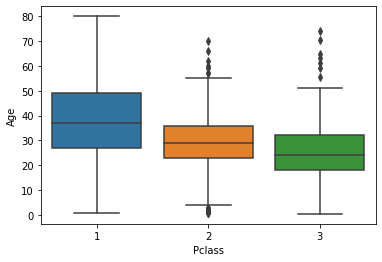

In [8]:
# Check visual evidence of correlation

# Take the rows where the age column in not NA 
train_data = train_data[train_data['Age'].notna()]

sns.boxplot(x='Pclass', y = 'Age', data = train_data)

df_a = train_data[(train_data['Pclass'] == 1)]['Age']
df_b = train_data[(train_data['Pclass'] == 2)]['Age']
df_c = train_data[(train_data['Pclass'] == 3)]['Age']

paired_df = train_data[['Pclass','Age']]


In [9]:
f_oneway(df_a.to_list(), df_b.to_list(), df_c.to_list())

F_onewayResult(statistic=57.443484340676214, pvalue=7.487984171959904e-24)

In [10]:
# Pairwise Tukey HSD test 
tukey = pairwise_tukeyhsd(endog=paired_df['Age'],
                          groups=paired_df['Pclass'],
                          alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2  -8.3558 0.001 -11.7042  -5.0074   True
     1      3 -13.0928 0.001 -15.9623 -10.2234   True
     2      3   -4.737 0.001  -7.6764  -1.7977   True
-----------------------------------------------------


In [11]:
# The group means across 2 and 3 are not siginificantly different. 
# Hence, we can impute the Age according to passenger categories such as class 1 and 2+3 but 
# cannot differentiate between 2 and 3. 
# use the same means across passenger class 2 and 3. 

In [12]:
# replace the values for age with the means in the specific groups. 
mean_age_group1 = round(train_data[(train_data['Pclass'] ==1)]['Age'].mean(),2)
mean_age_group2 = round(train_data[(train_data['Pclass'] == 3) | (train_data['Pclass'] == 2)]['Age'].mean(),2)

print(mean_age_group1)
print(mean_age_group2)

38.23
26.69


In [13]:
# Impute the values using the Pclass statistics 

# Imputation function
def impute_age(row):
    Age = row[0]  # Age is the dependent variable. 
    Pclass = row[1]  # Pclass is the independent variable. 
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38

        elif Pclass == 2 or Pclass == 3:
            
            return 27

    else:
        return Age
    
# Apply the function to the Age column
total_data_['Age']=total_data_[['Age','Pclass']].apply(impute_age, axis =1)    

In [14]:
# how is the correlation plot being used between numerical 
# and categorical variable. 

# Pandas and Numpy both have NAN detection libraries. 
pd.isna(2)
pd.isna([2,3,4,np.nan,6,7])

np.isnan(2)
np.isnan([2,3,4,np.nan, 6,7])

np.median([3,4,5, np.nan, 7,8])

nan

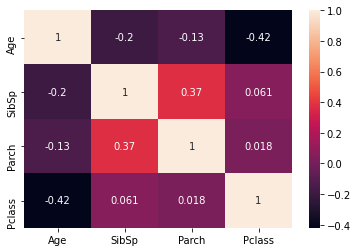

In [15]:
sns.heatmap(total_data_[["Age","Sex","SibSp","Parch","Pclass"]].corr(), annot = True)
# the correlation is plotted between the numerical variables. 
plt.show()

In [16]:
# Sibsp: no: of sibling spouse aboard. 
# Parch: No: of Parents / children aboard. 

#### Impute Fare and Embarked 


<AxesSubplot:>

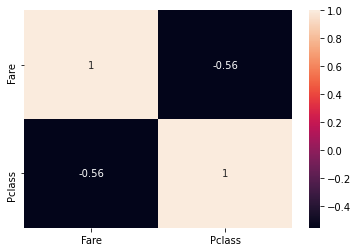

In [17]:
sns.heatmap(total_data_[['Fare', 'Pclass']].corr(), annot=True)


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

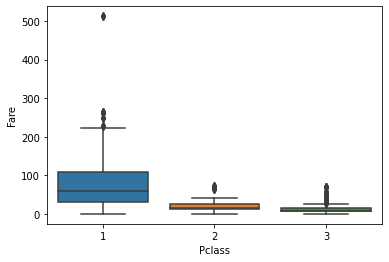

In [18]:
sns.boxplot(x='Pclass', y='Fare', data=total_data_)
# the boxplot shows not much difference in class 2 and 3 and these two data points 
# can be combined. 

In [19]:
total_data_[total_data_['Fare'].isnull()]
# calculate the average fare for Pclass = 2 and 3 and impute using that value . 

condition1 = total_data_['Pclass'] == 2
condition2 = total_data_['Pclass'] == 3
median_fare = total_data_[(condition1) | (condition2)]['Fare'].median()
print(median_fare)




10.5


In [20]:

fare_nan_index = list(total_data_[total_data_['Fare'].isnull()].index)

for i in fare_nan_index: 
    total_data_['Fare'].iloc[i]= median_fare

total_data_[total_data_['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### 3. Impute Embarked Values. 

<AxesSubplot:xlabel='Embarked', ylabel='count'>

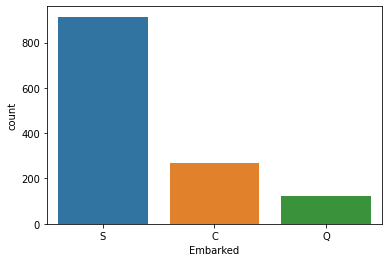

In [21]:
total_data_[total_data_['Embarked'].isnull()]

# Countplot used to plot the counts of each of the categories. 
sns.countplot(total_data_['Embarked'])

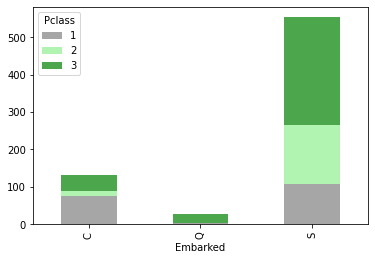

In [22]:
# since there are only 2 values missing in the Embarked column. 
# the passengers embarked from any of these three locations. 
# we can just replace it with the mode. 

parch = train_data.groupby(['Embarked','Pclass']).Parch.count().unstack()
p3 = parch.plot(kind = 'bar', stacked = True,
                   color = ['grey','lightgreen', 'green'], alpha = .70)

In [23]:
total_data_[total_data_['Embarked'].isnull()]
# since the missing values belong to Pclass 1. 
# and Pclass 1 are distributed across 'C' and 'S'. 'S' is more frequent. 

embarked_nan_index = list(total_data_[total_data_['Embarked'].isnull()].index)

embarked_mode = total_data_['Embarked'].mode()[0]
embarked_mode2 = total_data_[(total_data_['Pclass'] == 1)]['Embarked'].mode()[0]

for i in embarked_nan_index:
    total_data_['Embarked'].iloc[i] = embarked_mode2
    print(total_data_['Embarked'].iloc[i])


S
S


In [24]:
embarked_mode2[0]


'S'

In [25]:
total_data_[total_data_['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


#### Drop the cabin column. 

In [26]:
# too many missing values in the cabin column. 
total_data_.drop(['Cabin'], axis=1, inplace=True)

In [27]:
# Data types
print(total_data_.info())

# Identify non-null objects
print('\n')
print('Non-Null Objects to Be Converted to Category')
print(total_data_.select_dtypes(['object']).columns)

total_data_.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB
None


Non-Null Objects to Be Converted to Category
Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')


PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [28]:
total_data_.drop(['Name', 'Ticket'], axis=1, inplace=True)
objcat = ['Sex', 'Embarked']

for colname in objcat:
    total_data_[colname] = total_data_[colname].astype('category')

In [29]:
# only numerical variables can be described. 
total_data_.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1309.0,29.630000,13.011553,0.17,22.0000,27.0000,37.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1309.0,33.278065,51.742715,0.00,7.8958,14.4542,31.275,512.3292


In [30]:
total_data_.drop(['PassengerId'], axis=1, inplace=True)

### Exploratory Data Analysis 
1. Target Variable count and countplot

#### Target Variable

Target Variable
Survived
0.0    549
1.0    342
Name: Survived, dtype: int64


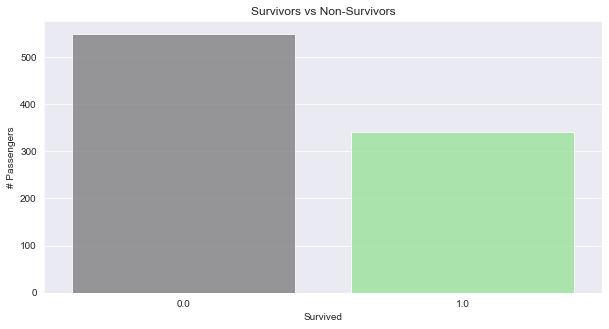

In [31]:
# Survival Count
print('Target Variable')
print(total_data_.groupby(['Survived'])['Survived'].count())

# groupby will happen by survived but the metric to display on the right side. 
#  depends. Select column and the aggregation method. 

sns.set_style('darkgrid')
plt.figure(figsize=(10,5))

# alpha indicates the transparency of the graph. 
# 
sns.countplot(total_data_['Survived'], alpha  =0.8, palette = ['grey', 'lightgreen'] )
plt.title('Survivors vs Non-Survivors')
plt.ylabel('# Passengers')
plt.show()


#### Numeric Variables
The numerical variables consist of: 
1. Continuous Variables 
2. Discrete Variables

Continuous Variables
       count       mean        std   min      25%      50%     75%       max
Age   1309.0  29.630000  13.011553  0.17  22.0000  27.0000  37.000   80.0000
Fare  1309.0  33.278065  51.742715  0.00   7.8958  14.4542  31.275  512.3292
________________________________________________________________________________
Discrete Variables
Pclass
1    323
2    277
3    709
Name: Pclass, dtype: int64
SibSp
0    891
1    319
2     42
3     20
4     22
5      6
8      9
Name: SibSp, dtype: int64
Parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Parch, dtype: int64


Text(0.5, 1.0, 'Age Distribution')

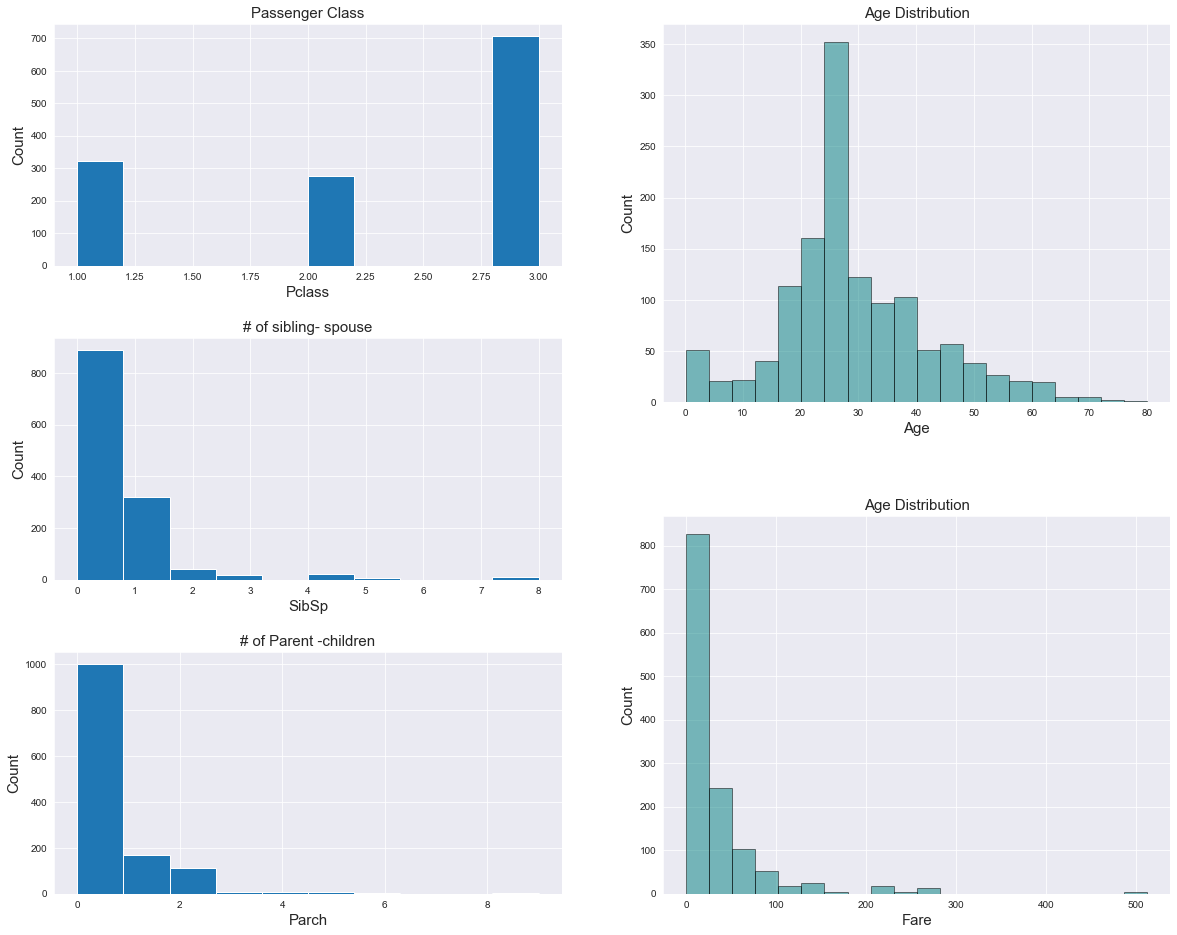

In [32]:
print('Continuous Variables')
print(total_data_[['Age','Fare']].describe().transpose())
print('__'* 40)

print('Discrete Variables')
print(total_data_.groupby(['Pclass'])['Pclass'].count())
print(total_data_.groupby(['SibSp'])['SibSp'].count())
print(total_data_.groupby(['Parch'])['Parch'].count())

# Subplots of numeric features 
sns.set_style('darkgrid')
fig = plt.figure(figsize=(20,16))
fig.subplots_adjust(hspace=0.30)

ax1 = fig.add_subplot(321)
ax1.hist(total_data_['Pclass'])

# with ax , need to write set_xlabel and set_ylabel functions. 
ax1.set_xlabel('Pclass', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Passenger Class', fontsize=15)

ax2 = fig.add_subplot(323)
ax2.hist(total_data_['SibSp'])
ax2.set_xlabel('SibSp', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.set_title('# of sibling- spouse', fontsize=15)

ax3 = fig.add_subplot(325)
ax3.hist(total_data_['Parch'])
ax3.set_xlabel('Parch', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.set_title('# of Parent -children', fontsize=15)

ax4 = fig.add_subplot(222)
ax4.hist(total_data_['Age'], bins=20, alpha=0.50, edgecolor='black', color = 'teal')
ax4.set_xlabel('Age', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)
ax4.set_title('Age Distribution', fontsize=15)

ax5 = fig.add_subplot(224)
ax5.hist(total_data_['Fare'], bins=20, alpha=0.50, edgecolor='black', color = 'teal')
ax5.set_xlabel('Fare', fontsize=15)
ax5.set_ylabel('Count', fontsize=15)
ax5.set_title('Age Distribution', fontsize=15)



1. Fare has a long-tail distribution. Bulk of the fare is under $25 with a median fare of $14, data is skewed to the right up to $500. 
2. Majority of travellers: 3rd class, without any spouse or children. single. 30 and below. median age. 

In [33]:
# create bins -> count the people in each age bin. 
# create a cumulative count. 

df_age_bin = pd.DataFrame(total_data_['Age'].value_counts(bins=20, sort=False))
df_age_bin['Age_Bin'] = round(df_age_bin['Age'].cumsum() * 100/df_age_bin['Age'].sum(),2)
df_age_bin

# Age 28 and below account for 58% of the total population. 
# Most of the population was young. 

,Age,Age_Bin
"(0.0892, 4.162]",51,3.90
"(4.162, 8.153]",21,5.50
"(8.153, 12.144]",22,7.18
"(12.144, 16.136]",40,10.24
"(16.136, 20.128]",114,18.95
"(20.128, 24.119]",160,31.17
"(24.119, 28.11]",352,58.06
"(28.11, 32.102]",122,67.38
"(32.102, 36.094]",97,74.79
"(36.094, 40.085]",103,82.66


In [34]:
df_fare_bin = pd.DataFrame(total_data_['Fare'].value_counts(bins=20, sort=False))
df_fare_bin['Fare_Bin'] = round(df_fare_bin['Fare'].cumsum() * 100/df_fare_bin['Fare'].sum(),2)

# Fare has a long-tail distribution. 
# More than half of the passengers paid a fare of $26 and less. 
# median fare. 
print('Median Fare:', round(total_data_['Fare'].median(),2))
df_fare_bin

Median Fare: 14.45


,Fare,Fare_Bin
"(-0.513, 25.616]",828,63.25
"(25.616, 51.233]",243,81.82
"(51.233, 76.849]",102,89.61
"(76.849, 102.466]",52,93.58
"(102.466, 128.082]",17,94.88
"(128.082, 153.699]",25,96.79
"(153.699, 179.315]",4,97.10
"(179.315, 204.932]",0,97.10
"(204.932, 230.548]",18,98.47
"(230.548, 256.165]",3,98.70


In [35]:
# Explore continuous and Factor Variables. 
# Continuous: Age, Fare
# Factor: Age, Pclass, Parch, Sibsp
# Target vs continuous variables. 

print('Statistical Summary of Age and Fare')
print('\n') # Break. 
print('Did Not Survive')
print(total_data_[total_data_['Survived']==0][['Age', 'Fare']].describe().transpose())
print('\n') # Break. 

print('Survive')
print(total_data_[total_data_['Survived']==1][['Age', 'Fare']].describe().transpose())


Statistical Summary of Age and Fare


Did Not Survive
      count       mean        std  min      25%   50%   75%    max
Age   549.0  30.121129  12.608811  1.0  23.0000  27.0  37.0   74.0
Fare  549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0


Survive
      count       mean        std   min     25%   50%    75%       max
Age   342.0  28.589678  13.907295  0.42  21.000  27.0  36.75   80.0000
Fare  342.0  48.395408  66.596998  0.00  12.475  26.0  57.00  512.3292


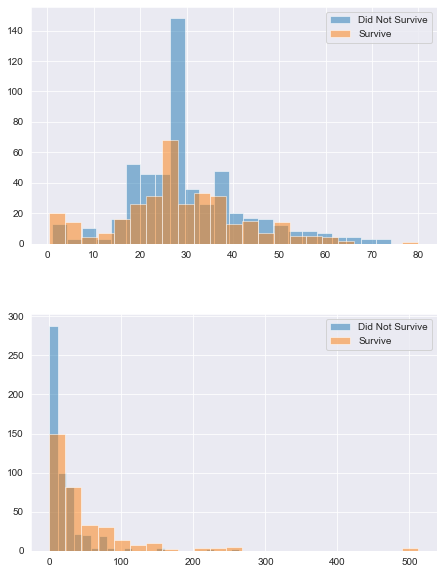

In [36]:
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(total_data_[total_data_['Survived'] ==0].Age, bins=23, label='Did Not Survive', alpha=0.5)
ax1.hist(total_data_[total_data_['Survived'] ==1].Age, bins=23, label='Survive', alpha=0.5)
ax1.legend()

ax2 = fig.add_subplot(223)
ax2.hist(total_data_[total_data_['Survived'] ==0].Fare, bins=23, label='Did Not Survive', alpha=0.5)
ax2.hist(total_data_[total_data_['Survived'] ==1].Fare, bins=23, label='Survive', alpha=0.5)
ax2.legend()


# < 10 years old survived. but the younger people in 18-30 range, majority didn't survive.
# those who paid < $25 didn't survive much. 
# those who paid > $100 as fare tend to 
# survive more than those who paid lower fares.

### Getting model ready

In [37]:
sex = pd.get_dummies(total_data_['Sex'], drop_first=True)
embarked = pd.get_dummies(total_data_['Embarked'], drop_first=True)

total_data_ = pd.concat([total_data_, sex, embarked], axis=1)

In [38]:
total_data_.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [39]:
total_data_.head()
# Split the cleaned dataset into trained and test. 

# when train and test are concatted, the indices remain. 
# the rows don't get jumbled up. 
train_data = total_data_[0:len(train_data)]
test_data = total_data_[len(train_data):]

In [40]:
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1


In [43]:
y= train_data['Survived']
x = train_data.drop(['Survived'], axis=1)


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=101)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Creating an Instance for the model
lreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=13)
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=200)


# Fit on the Training Data 
lreg.fit(x_train, y_train)
svc.fit(x_train, y_train)
knn.fit(x_train, y_train)
dtree.fit(x_train, y_train)
rfc.fit(x_train, y_train)


# Predict 
y_pred_lreg = lreg.predict(x_test)
y_pred_svc = svc.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_dtree = knn.predict(x_test)
y_pred_rfc = knn.predict(x_test)

# Confusion Matrix 
lreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
svc_accuracy = round(accuracy_score(y_test, y_pred_svc) * 100,2)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn)*100,2)
dtree_accuracy = round(accuracy_score(y_test, y_pred_dtree)*100,2)
rfc_accuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)

print('LReg:',lreg_accuracy)
print('SVC:',svc_accuracy)
print('KNN:',knn_accuracy)
print('DTree:',dtree_accuracy)
print('RFC:',rfc_accuracy)



LReg: 68.53
SVC: 65.03
KNN: 66.43
DTree: 66.43
RFC: 66.43


In [45]:
y_train = train_data['Survived']
x_train = train_data.drop(['Survived'], axis=1)
x_test = test_data.drop(['Survived'], axis=1)

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=101)

lreg2 = LogisticRegression()
lreg2.fit(x_train, y_train)

y_pred = lreg2.predict(x_test)

x_train (714, 8)
y_train (714,)
x_test (595, 8)
